# Connection

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155013 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

adc.json  drive  sample_data


# Data preprocessing

## Library

In [ ]:
import numpy as np
import numpy
import csv
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


## Data set

In [ ]:
from openpyxl import Workbook,load_workbook 
df = pd.read_csv('/content/drive/Colab Notebooks/IBM/loan_train.csv')
df.head() 

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data pre-processing

In [ ]:
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

## Data visualization

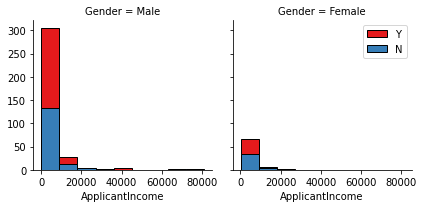

In [ ]:
bins = np.linspace(df.ApplicantIncome.min(), df.ApplicantIncome.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="Loan_Status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'ApplicantIncome', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

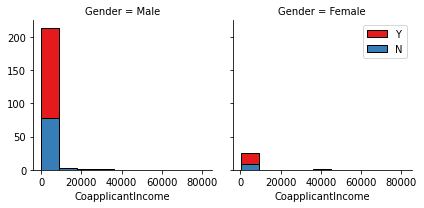

In [ ]:
bins = np.linspace(df.ApplicantIncome.min(), df.ApplicantIncome.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="Loan_Status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'CoapplicantIncome', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Convert

In [ ]:
df.groupby(['Gender'])['Loan_Status'].value_counts(normalize=True)

Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.693252
        N              0.306748
Name: Loan_Status, dtype: float64

In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
df.groupby(['Education'])['Loan_Status'].value_counts(normalize=True)

Education     Loan_Status
Graduate      Y              0.708333
              N              0.291667
Not Graduate  Y              0.611940
              N              0.388060
Name: Loan_Status, dtype: float64

In [ ]:
df.groupby(['Gender'])['Loan_Status'].value_counts(normalize=True)

Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.693252
        N              0.306748
Name: Loan_Status, dtype: float64

In [ ]:
Feature = df[['ApplicantIncome','Loan_Amount_Term','LoanAmount','Gender','CoapplicantIncome']]
Feature = pd.concat([Feature,pd.get_dummies(df['Education'])], axis=1)
Feature.head()

,ApplicantIncome,Loan_Amount_Term,LoanAmount,Gender,CoapplicantIncome,Graduate,Not Graduate
0,5849,360.0,NaN,Male,0.0,1,0
1,4583,360.0,128.0,Male,1508.0,1,0
2,3000,360.0,66.0,Male,0.0,1,0
3,2583,360.0,120.0,Male,2358.0,0,1
4,6000,360.0,141.0,Male,0.0,1,0


In [ ]:
X = Feature
X[0:5]

,ApplicantIncome,Loan_Amount_Term,LoanAmount,Gender,CoapplicantIncome,Graduate,Not Graduate
0,5849,360.0,NaN,Male,0.0,1,0
1,4583,360.0,128.0,Male,1508.0,1,0
2,3000,360.0,66.0,Male,0.0,1,0
3,2583,360.0,120.0,Male,2358.0,0,1
4,6000,360.0,141.0,Male,0.0,1,0


In [ ]:
y = df['Loan_Status'].values
y[0:5]

array(['Y', 'N', 'Y', 'Y', 'Y'], dtype=object)

# Classification

## Logistic Regression

### Kütüphane

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import neighbors


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Model ve Tahmin

In [ ]:
df["ApplicantIncome"].value_counts() # Bağımlı değişken hakkında bilgi

2500    9
4583    6
2600    6
6000    6
5000    5
       ..
5818    1
5819    1
5821    1
2750    1
3691    1
Name: ApplicantIncome, Length: 505, dtype: int64

In [ ]:
df.describe().T # Bağımsız değişkenlerin kısa istatistik özeti

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [ ]:
y= df["ApplicantIncome"]
X = df.drop(["ApplicantIncome"], axis = 1)

In [ ]:
y.head()

0    5849
1    4583
2    3000
3    2583
4    6000
Name: ApplicantIncome, dtype: int64

In [ ]:
X.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
loj_model = LogisticRegression(solver= "liblinear").fit(X,y)

In [ ]:
loj_model.intercept_ # sabit değerimiz

In [ ]:
loj_model.coef_ #bağımsız değişkenlerin kat sayıları

array([[ 1.17098692e-01,  2.83673379e-02, -1.69010912e-02,
         7.40100722e-04, -6.42594633e-04,  5.96676293e-02,
         6.83738130e-01,  7.20115615e-03]])

In [ ]:
loj_model.predict(X)[0:10]

In [ ]:
y[0:10]

In [ ]:
y_pred = loj_model.predict(X)
confusion_matrix(y, y_pred) # karmaşıklık matrisi

In [ ]:
accuracy_score(y, y_pred)# doğruluk oranı

In [ ]:
print(classification_report(y, y_pred)) # Sınıflandırma raporu

In [ ]:
loj_model.predict_proba(X)[0:10] # sınıf olasılıkları

In [ ]:
# Roc eğrisi
logit_roc_auc =roc_auc_score(y, loj_model.predict(X))
fpr, tpr, thresholds = roc_curve(y, loj_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('log_Roc')
plt.show()

### Model Tuning (Model Doğrulama)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30,
                                                    random_state=42)

In [ ]:
loj_model = LogisticRegression(solver= "liblinear").fit(X_train,y_train)

In [ ]:
y_pred =loj_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7619047619047619


In [ ]:
# k katlı çarpazlama ile hatamız
cross_val_score(loj_model, X_test, y_test, cv= 10).mean()

0.7704710144927536

## KNN

### Kütüphane

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import neighbors


In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

### Model Ve Tahmin

In [ ]:
knn_model = KNeighborsClassifier().fit(X_train, y_train)
knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6883116883116883

In [ ]:
print(classification_report(y_test, y_pred))

### Model Tuning

In [ ]:
knn = KNeighborsClassifier()
knn_params = {"n_neighbors": np.arange(1,50)}

In [ ]:
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)

In [ ]:
knn_cv_model.best_params_

{'n_neighbors': 11}

In [ ]:
knn_cv_model.best_score_

0.748637316561845

In [ ]:
knn_tuned = KNeighborsClassifier(n_neighbors= 11).fit(X_train, y_train)

In [ ]:
y_pred = knn_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7316017316017316

In [ ]:
# accuracy_score için farklı yöntem
knn_tuned.score(X_test, y_test)

0.7316017316017316

## Decision Tree

### Kütüphane

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import neighbors


In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

### Model ve Tahmin

In [ ]:
cart_model = DecisionTreeClassifier().fit(X_train, y_train)
cart_model

In [ ]:
y_pred = cart_model.predict(X_test)
accuracy_score(y_test, y_pred)

### Model Tuning

In [ ]:
cart = DecisionTreeClassifier()

In [ ]:
cart_params = {"max_depth": [1,3,5,8,10],
               "min_samples_split": [2,3,5,10,20,50]}

In [ ]:
cart_cv_model = GridSearchCV(cart, cart_params, cv=10, n_jobs=-1, verbose= 2).fit(X_train, y_train)

In [ ]:
cart_cv_model.best_params_

In [ ]:
#final model
cart_tuned = DecisionTreeClassifier(max_depth=5, min_samples_split=20).fit(X_train,y_train)

In [ ]:
y_pred= cart_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7532467532467533

## SVM

### Kütüphane

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import neighbors


In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

### Model ve Tahmin

In [ ]:
svm_model = SVC(kernel = "linear").fit(X_train, y_train)

In [ ]:
svm_model

In [ ]:
y_pred = svm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7445887445887446

### Model Tuning

In [ ]:
svm = SVC()

In [ ]:
svm_params = {"C": np.arange(1,5), "kernel": ["linear","rbf"]} # liner ve liner olmayan kernelleri denemek için

In [ ]:
svm_cv_model = GridSearchCV(svm, svm_params, cv = 5, n_jobs=-1, verbose=2).fit(X_train, y_train)

In [ ]:
svm_cv_model.best_score_

0.7839044652128765

In [ ]:
svm_cv_model.best_params_

In [ ]:
#final model
svm_tuned = SVC(C=2, kernel= "linear").fit(X_train, y_train)

In [ ]:
y_pred = svm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7445887445887446